In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported.")

Libraries imported.


In [10]:
splits_dir = "../data/splits"
train_df = pd.read_csv(os.path.join(splits_dir, "train.csv"))
val_df = pd.read_csv(os.path.join(splits_dir, "validation.csv"))
test_df = pd.read_csv(os.path.join(splits_dir, "test.csv"))

print("Data splits loaded.")
print(f"Train: {train_df.shape}, Val: {val_df.shape}, Test: {test_df.shape}")

Data splits loaded.
Train: (3460, 44), Val: (742, 44), Test: (742, 44)


In [11]:
target_col = 'price'
feature_cols = [col for col in train_df.columns if col != target_col]

X_train = train_df[feature_cols]
y_train = train_df[target_col]
X_val = val_df[feature_cols]
y_val = val_df[target_col]
X_test = test_df[feature_cols]
y_test = test_df[target_col]

print(f"Number of features: {len(feature_cols)}")

Number of features: 43


In [12]:
def get_metrics(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name):
    """Return dictionary of metrics for a model."""
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    return {
        'Model': model_name,
        'Train RMSE': train_rmse,
        'Val RMSE': val_rmse,
        'Test RMSE': test_rmse,
        'Train MAE': train_mae,
        'Val MAE': val_mae,
        'Test MAE': test_mae,
        'Train R2': train_r2,
        'Val R2': val_r2,
        'Test R2': test_r2
    }, y_test_pred

In [13]:
# Define paths
baseline_dir = "../models/baseline_models"
tuned_dir = "../models/tuned_models"

# Model file names (adjust if your filenames differ)
baseline_files = {
    'XGBoost (Regularized)': 'xgboost_regularized.joblib',
    'LightGBM (Regularized)': 'lightgbm_regularized.joblib',
    'CatBoost (Regularized)': 'catboost_regularized.joblib'
}

tuned_files = {
    'XGBoost (Tuned)': 'xgboost_tuned.joblib',
    'LightGBM (Tuned)': 'lightgbm_tuned.joblib',
    'CatBoost (Tuned)': 'catboost_tuned.joblib'
}

all_models = {}
metrics_list = []
predictions = {}

# Load baseline models
for name, filename in baseline_files.items():
    path = os.path.join(baseline_dir, filename)
    if os.path.exists(path):
        model = joblib.load(path)
        all_models[name] = model
        metrics, y_pred = get_metrics(model, X_train, y_train, X_val, y_val, X_test, y_test, name)
        metrics_list.append(metrics)
        predictions[name] = y_pred
        print(f"Loaded {name}")
    else:
        print(f"Warning: {path} not found")

# Load tuned models
for name, filename in tuned_files.items():
    path = os.path.join(tuned_dir, filename)
    if os.path.exists(path):
        model = joblib.load(path)
        all_models[name] = model
        metrics, y_pred = get_metrics(model, X_train, y_train, X_val, y_val, X_test, y_test, name)
        metrics_list.append(metrics)
        predictions[name] = y_pred
        print(f"Loaded {name}")
    else:
        print(f"Warning: {path} not found")

Loaded XGBoost (Regularized)
Loaded LightGBM (Regularized)
Loaded CatBoost (Regularized)
Loaded XGBoost (Tuned)
Loaded LightGBM (Tuned)
Loaded CatBoost (Tuned)


In [14]:
metrics_df = pd.DataFrame(metrics_list)
metrics_df.set_index('Model', inplace=True)

print("\n" + "="*80)
print("COMPARISON OF ALL 6 MODELS (TEST SET)")
print("="*80)
print(metrics_df[['Test RMSE', 'Test MAE', 'Test R2']].round(4))

# Add overfitting gap (Val - Train RMSE)
metrics_df['Overfit Gap'] = metrics_df['Val RMSE'] - metrics_df['Train RMSE']


COMPARISON OF ALL 6 MODELS (TEST SET)
                        Test RMSE  Test MAE  Test R2
Model                                               
XGBoost (Regularized)     33.9078   24.6931   0.8609
LightGBM (Regularized)    32.4406   22.9183   0.8727
CatBoost (Regularized)    39.2436   28.9997   0.8137
XGBoost (Tuned)           29.9932   20.8737   0.8912
LightGBM (Tuned)          30.2234   20.9762   0.8895
CatBoost (Tuned)          37.5400   27.1943   0.8296


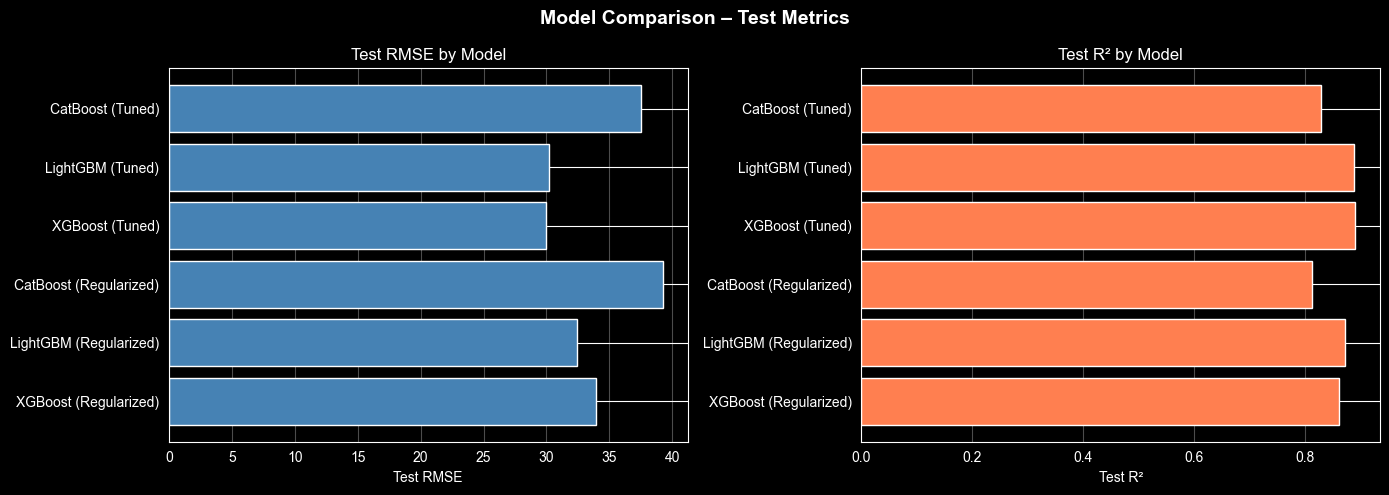

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Test RMSE
axes[0].barh(metrics_df.index, metrics_df['Test RMSE'], color='steelblue')
axes[0].set_xlabel('Test RMSE')
axes[0].set_title('Test RMSE by Model')
axes[0].grid(axis='x', alpha=0.3)

# Test R2
axes[1].barh(metrics_df.index, metrics_df['Test R2'], color='coral')
axes[1].set_xlabel('Test R²')
axes[1].set_title('Test R² by Model')
axes[1].grid(axis='x', alpha=0.3)

plt.suptitle('Model Comparison – Test Metrics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

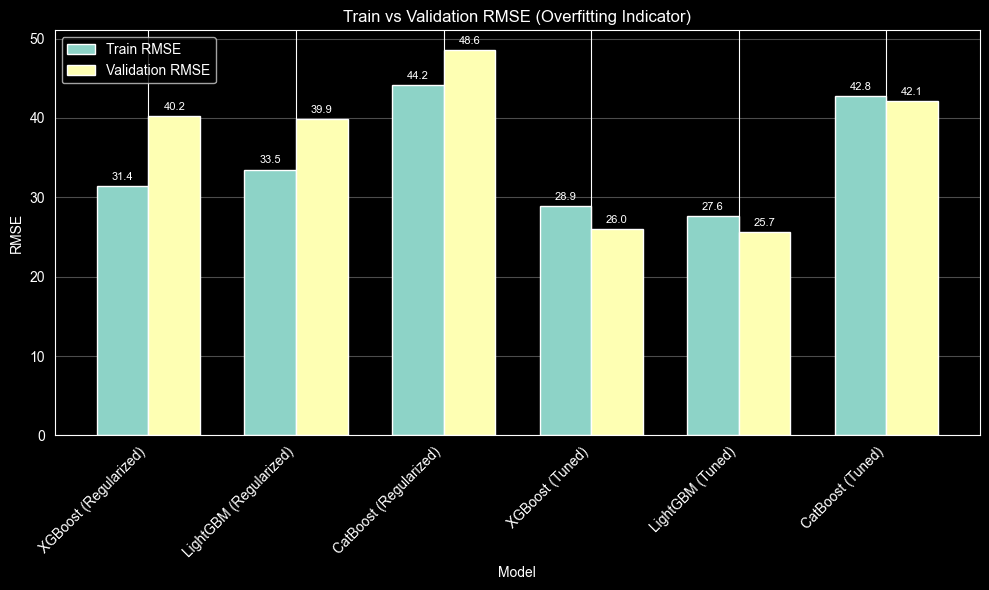

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(metrics_df.index))
width = 0.35

train_bars = ax.bar(x - width/2, metrics_df['Train RMSE'], width, label='Train RMSE')
val_bars = ax.bar(x + width/2, metrics_df['Val RMSE'], width, label='Validation RMSE')

ax.set_xlabel('Model')
ax.set_ylabel('RMSE')
ax.set_title('Train vs Validation RMSE (Overfitting Indicator)')
ax.set_xticks(x)
ax.set_xticklabels(metrics_df.index, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [train_bars, val_bars]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

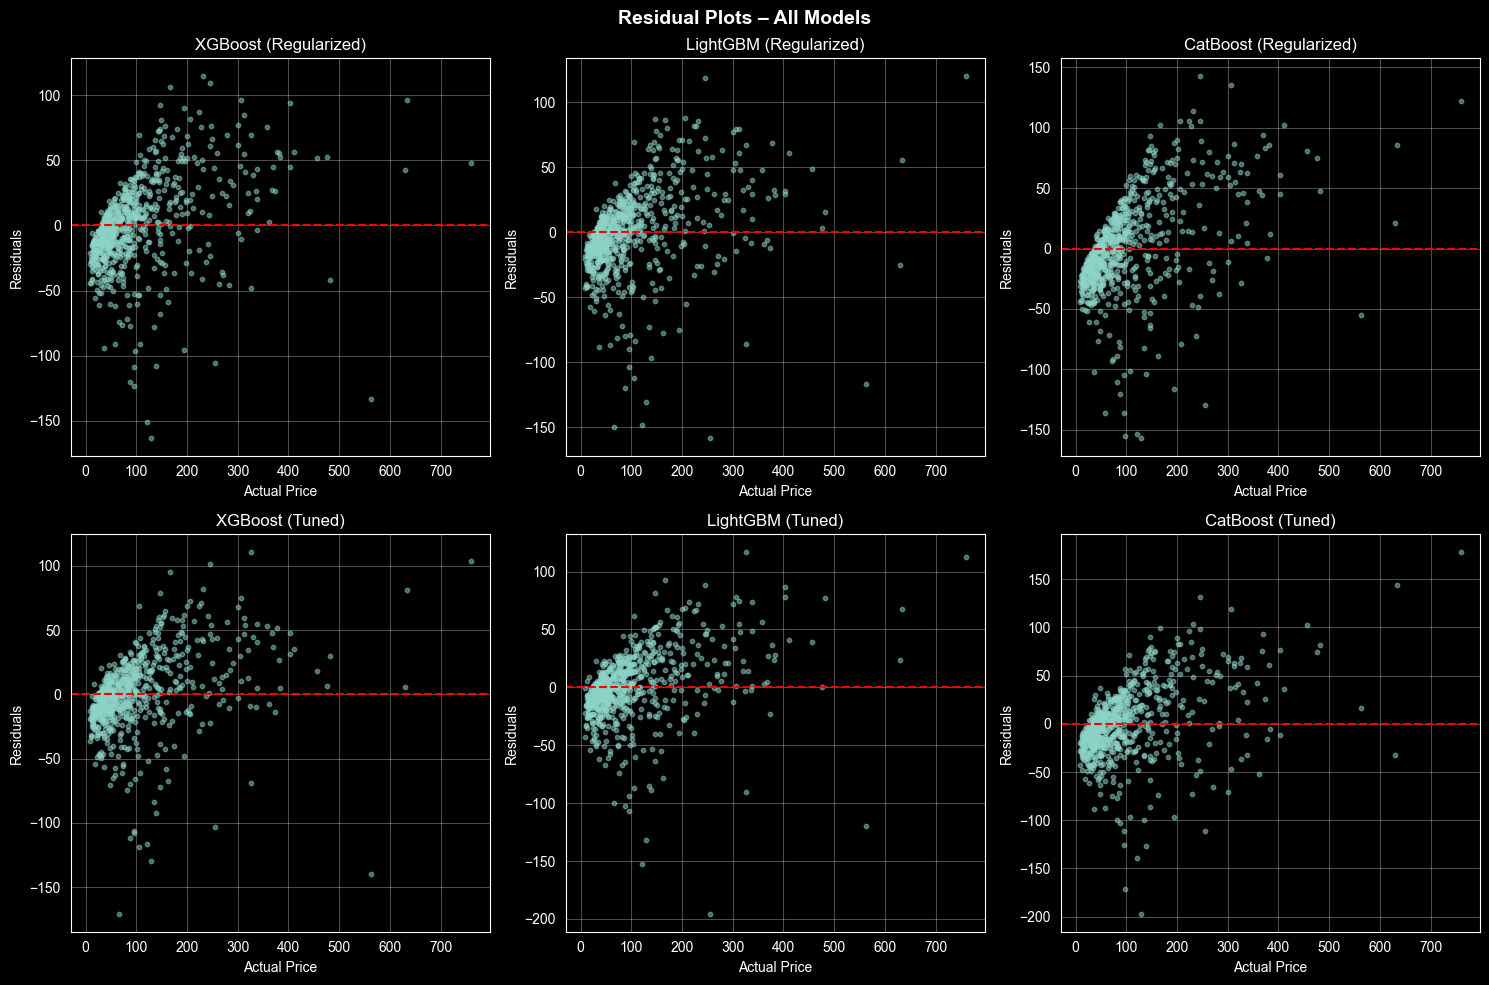

In [17]:
n_models = len(predictions)
cols = 3
rows = (n_models + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
axes = axes.flatten()

for i, (name, y_pred) in enumerate(predictions.items()):
    residuals = y_test - y_pred
    ax = axes[i]
    ax.scatter(y_test, residuals, alpha=0.5, s=10)
    ax.axhline(y=0, color='red', linestyle='--')
    ax.set_title(name)
    ax.set_xlabel('Actual Price')
    ax.set_ylabel('Residuals')
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Residual Plots – All Models', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

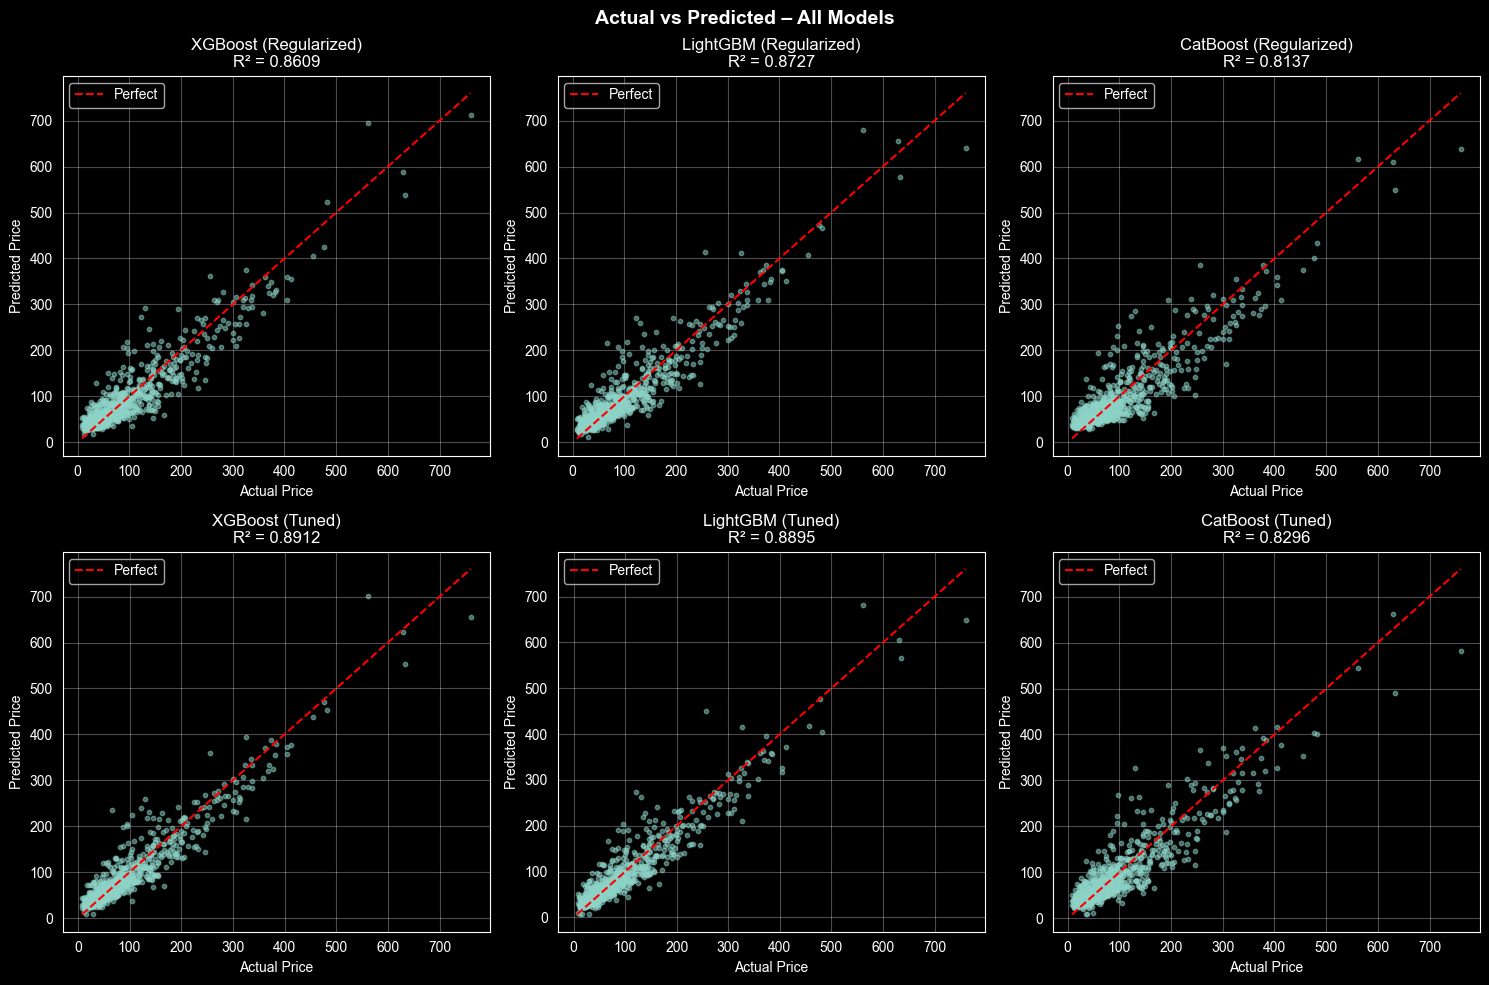

In [18]:
fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
axes = axes.flatten()

for i, (name, y_pred) in enumerate(predictions.items()):
    ax = axes[i]
    ax.scatter(y_test, y_pred, alpha=0.5, s=10)
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect')
    ax.set_title(f'{name}\nR² = {metrics_df.loc[name, "Test R2"]:.4f}')
    ax.set_xlabel('Actual Price')
    ax.set_ylabel('Predicted Price')
    ax.legend()
    ax.grid(True, alpha=0.3)

for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Actual vs Predicted – All Models', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Top 3 models by Test R2: ['XGBoost (Tuned)', 'LightGBM (Tuned)', 'LightGBM (Regularized)']


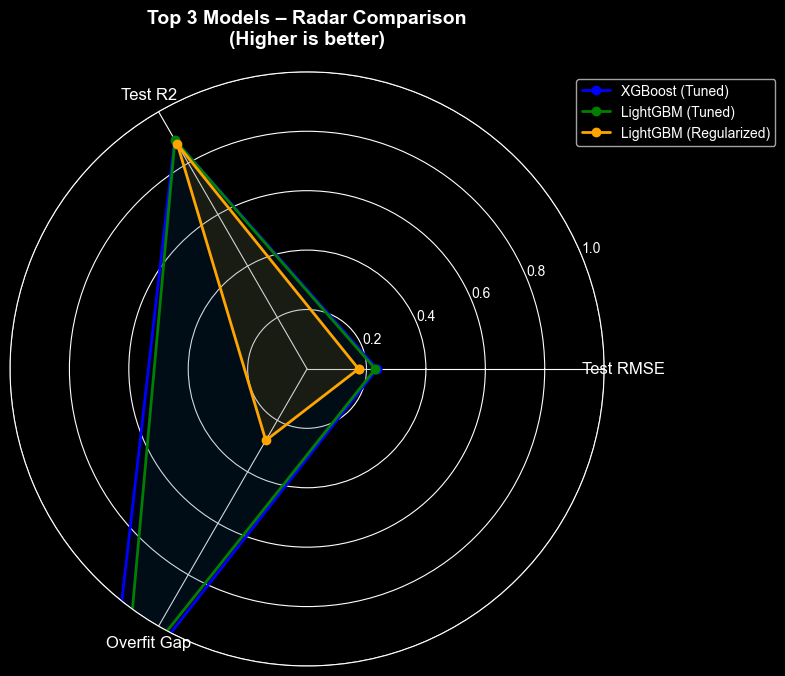

In [19]:
from math import pi

# Select top 3 models by test R2
top3 = metrics_df.nlargest(3, 'Test R2').index.tolist()
print("Top 3 models by Test R2:", top3)

# Prepare normalized metrics for radar
categories = ['Test RMSE', 'Test R2', 'Overfit Gap']
# For RMSE and overfit gap, lower is better → invert
max_rmse = metrics_df['Test RMSE'].max()
max_gap = metrics_df['Overfit Gap'].max()

def normalize(metrics_df, model):
    rmse = metrics_df.loc[model, 'Test RMSE']
    r2 = metrics_df.loc[model, 'Test R2']
    gap = metrics_df.loc[model, 'Overfit Gap']
    return [
        1 - rmse / max_rmse,
        r2,
        1 - gap / max_gap if max_gap > 0 else 1.0
    ]

N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
colors = ['blue', 'green', 'orange']
for i, model in enumerate(top3):
    values = normalize(metrics_df, model)
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=model, color=colors[i])
    ax.fill(angles, values, alpha=0.1, color=colors[i])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12)
ax.set_ylim(0, 1)
ax.set_title('Top 3 Models – Radar Comparison\n(Higher is better)', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
plt.tight_layout()
plt.show()

In [20]:
# Normalize metrics
metrics_df['RMSE_norm'] = 1 - (metrics_df['Test RMSE'] / metrics_df['Test RMSE'].max())
metrics_df['R2_norm'] = metrics_df['Test R2'] / metrics_df['Test R2'].max()
metrics_df['Gap_norm'] = 1 - (metrics_df['Overfit Gap'] / metrics_df['Overfit Gap'].max())

metrics_df['Composite'] = (0.4 * metrics_df['R2_norm'] +
                           0.3 * metrics_df['RMSE_norm'] +
                           0.3 * metrics_df['Gap_norm'])

best_model_name = metrics_df['Composite'].idxmax()
best_model = all_models[best_model_name]

print("\n" + "="*80)
print("🏆 BEST MODEL BY COMPOSITE SCORE")
print("="*80)
print(f"Model: {best_model_name}")
print(f"Test RMSE: {metrics_df.loc[best_model_name, 'Test RMSE']:.4f}")
print(f"Test R2: {metrics_df.loc[best_model_name, 'Test R2']:.4f}")
print(f"Overfit Gap: {metrics_df.loc[best_model_name, 'Overfit Gap']:.4f}")
print(f"Composite Score: {metrics_df.loc[best_model_name, 'Composite']:.4f}")


🏆 BEST MODEL BY COMPOSITE SCORE
Model: XGBoost (Tuned)
Test RMSE: 29.9932
Test R2: 0.8912
Overfit Gap: -2.9424
Composite Score: 0.8707


In [21]:
best_model_dir = "../models/best_model"
os.makedirs(best_model_dir, exist_ok=True)

# Save the model
best_filename = f"best_model_{best_model_name.replace(' ', '_').replace('(', '').replace(')', '').lower()}.joblib"
joblib.dump(best_model, os.path.join(best_model_dir, best_filename))
print(f"✅ Best model saved as: {best_filename}")

# Save model metadata
metadata = {
    'Best Model': best_model_name,
    'Test RMSE': metrics_df.loc[best_model_name, 'Test RMSE'],
    'Test R2': metrics_df.loc[best_model_name, 'Test R2'],
    'Overfit Gap': metrics_df.loc[best_model_name, 'Overfit Gap']
}
pd.DataFrame([metadata]).to_csv(os.path.join(best_model_dir, 'best_model_info.csv'), index=False)
print("✅ Best model metadata saved.")

✅ Best model saved as: best_model_xgboost_tuned.joblib
✅ Best model metadata saved.


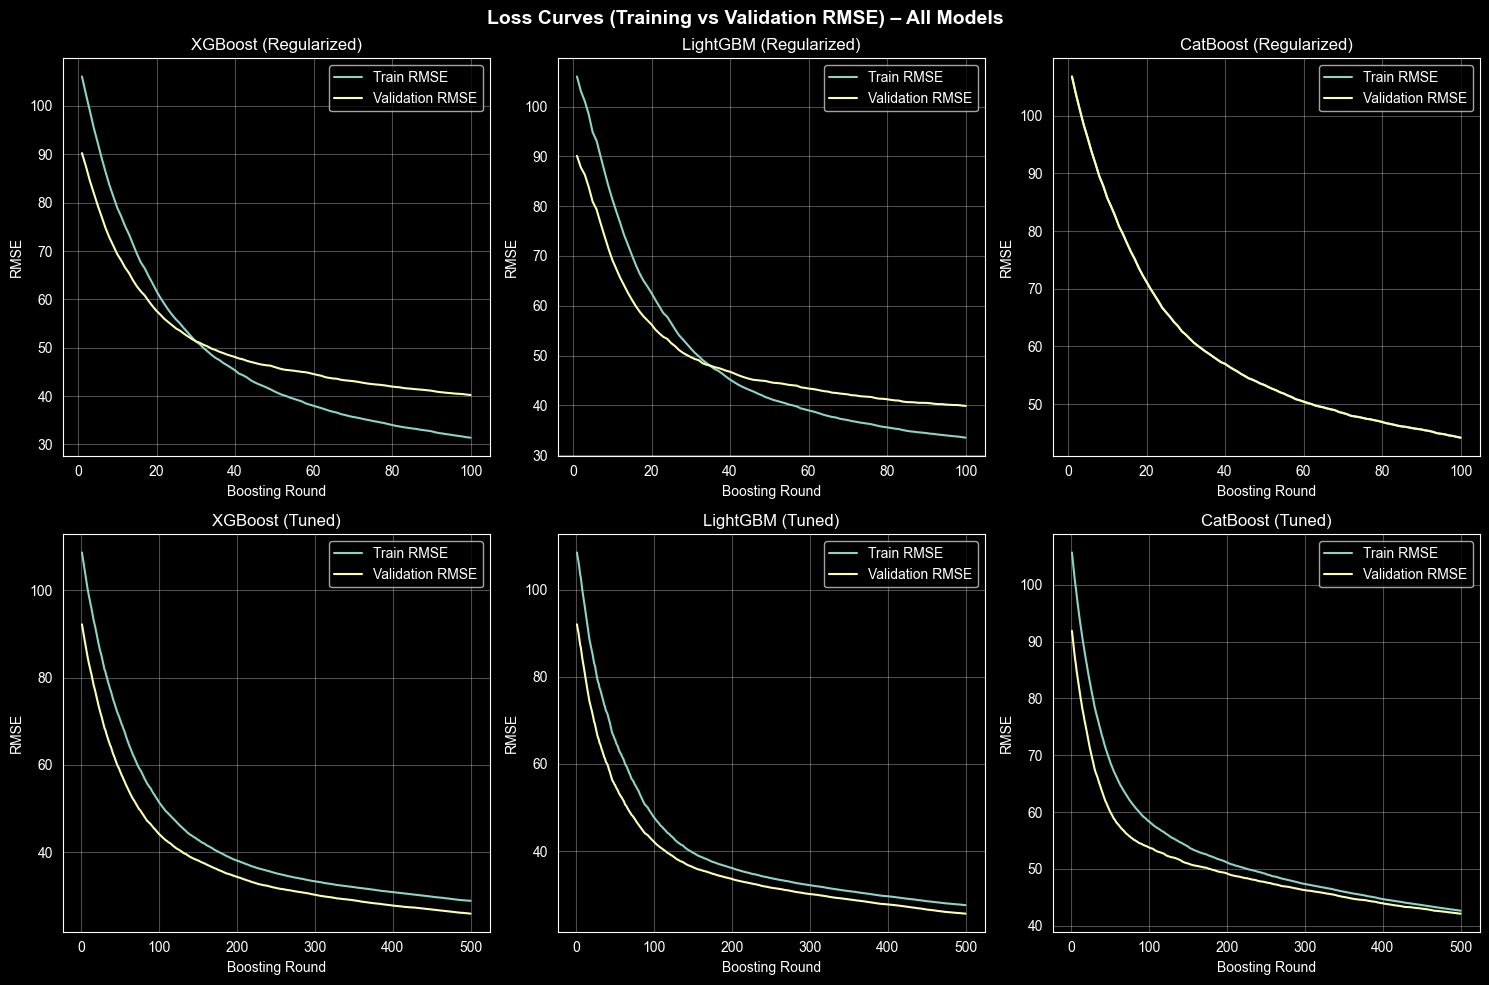

In [22]:
# Define a function to extract loss history robustly
def get_loss_history(model, model_name):
    """Return (train_rmse, val_rmse) lists from model's evals_result."""
    train_loss, val_loss = None, None
    try:
        if 'XGBoost' in model_name:
            results = model.evals_result()
            # XGBoost stores as validation_0 (train) and validation_1 (val)
            train_loss = results['validation_0']['rmse']
            val_loss = results['validation_1']['rmse']

        elif 'LightGBM' in model_name:
            results = model.evals_result_
            # LightGBM keys vary; find training and validation keys
            keys = list(results.keys())
            if 'training' in keys:
                train_key = 'training'
                val_key = [k for k in keys if k != 'training'][0]
            elif 'valid_0' in keys and 'valid_1' in keys:
                train_key = 'valid_0'
                val_key = 'valid_1'
            else:
                # fallback: assume first is train, second is val
                train_key = keys[0]
                val_key = keys[1]
            train_loss = results[train_key]['rmse']
            val_loss = results[val_key]['rmse']

        elif 'CatBoost' in model_name:
            results = model.get_evals_result()
            # CatBoost keys: 'learn' and 'validation_0', 'validation_1', etc.
            train_loss = results['learn']['RMSE']
            # We need the validation set that corresponds to the second eval set (X_val)
            if 'validation_1' in results:
                val_loss = results['validation_1']['RMSE']
            elif 'validation_0' in results:
                val_loss = results['validation_0']['RMSE']
            else:
                val_loss = results['learn']['RMSE']  # fallback (should not happen)

        return train_loss, val_loss
    except Exception as e:
        print(f"Could not extract loss history for {model_name}: {e}")
        return None, None

# Collect loss histories
loss_histories = {}
for name, model in all_models.items():
    train_l, val_l = get_loss_history(model, name)
    if train_l is not None:
        loss_histories[name] = (train_l, val_l)

# Plot loss curves in a 2x3 grid
n_models = len(loss_histories)
cols = 3
rows = (n_models + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
axes = axes.flatten()

for i, (name, (train_loss, val_loss)) in enumerate(loss_histories.items()):
    ax = axes[i]
    epochs = range(1, len(train_loss)+1)
    ax.plot(epochs, train_loss, label='Train RMSE')
    ax.plot(epochs, val_loss, label='Validation RMSE')
    ax.set_title(name)
    ax.set_xlabel('Boosting Round')
    ax.set_ylabel('RMSE')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Loss Curves (Training vs Validation RMSE) – All Models', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()